In [1]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torch.optim import Adam
from tqdm import tqdm

data_path = "./processed_data/"

In [2]:
# create image labels from annotations
images = []
labels = []

with open(data_path + "category.json", "r") as f:
    categories = json.load(f)
with open(data_path + "metadata.json", "r") as f:
    metadata = json.load(f)
    
category_indices = {cat['name']: idx for idx, cat in enumerate(categories)}

image_labels = {}

for image, values in metadata.items():
    image_file_name = values["filename"]
    
    if image_file_name not in image_labels:
        image_labels[image_file_name] = [0] * len(categories)
        
    for cat in values["categories"]:
        cat_index = category_indices[cat]
        image_labels[image_file_name][cat_index] = 1
        
image_labels = list(image_labels.items())

In [3]:
# image_labels[:5]

In [4]:
# len(image_labels)

In [5]:
# create Torch Dataset object

class MultiLabelDataset(Dataset):
    def __init__(self, image_labels, root_dir, transform=None):
        """
        Args:
            image_labels (list of tuples): List of tuples (image_path, label_vector).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_labels = image_labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_labels[idx][0])
        image = Image.open(img_name)
        labels = self.image_labels[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(labels)

In [18]:
# for project update using first 10000 images
image_labels = image_labels[:3000]

In [19]:
# load data into DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# train_data, val_data = train_test_split(image_labels, test_size=0.2, random_state=42)

# train_dataset = MultiLabelDataset(image_labels=train_data, root_dir=data_path+"images/", transform=transform)
# val_dataset = MultiLabelDataset(image_labels=val_data, root_dir=data_path+"images/", transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) 

train_val_data, test_data = train_test_split(image_labels, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

train_dataset = MultiLabelDataset(image_labels=train_data, root_dir=data_path+"images/", transform=transform)
val_dataset = MultiLabelDataset(image_labels=val_data, root_dir=data_path+"images/", transform=transform)
test_dataset = MultiLabelDataset(image_labels=test_data, root_dir=data_path+"images/", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
# define our model

model_vgg16 = models.vgg16(pretrained=True)

for param in model_vgg16.features.parameters():
    param.requires_grad = False

num_features = model_vgg16.classifier[0].in_features
num_categories = len(categories)

model_vgg16.classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, num_categories),
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16 = model_vgg16.to(device)

optimizer = Adam(model_vgg16.classifier.parameters(), lr=0.001)
loss_function = nn.BCELoss()

c:\Users\hrida\miniforge3\envs\new_environment\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hrida\miniforge3\envs\new_environment\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
#hyperparameter Tuning
import optuna
from tqdm import tqdm

def objective(trial):

    model_vgg16 = models.vgg16(pretrained=True)
    for param in model_vgg16.features.parameters():
        param.requires_grad = False

    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

    num_features = model_vgg16.classifier[0].in_features

    model_vgg16.classifier = nn.Sequential(
        nn.Linear(num_features, 4096),
        nn.ReLU(),
        nn.Dropout(dropout_rate),  # Using suggested dropout rate
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(dropout_rate),  # Using suggested dropout rate
        nn.Linear(4096, num_categories),
        nn.Sigmoid()
    )
    model_vgg16 = model_vgg16.to(device)

    optimizer = Adam(model_vgg16.classifier.parameters(), lr=lr)

    for epoch in range(2):
        model_vgg16.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model_vgg16(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model_vgg16.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model_vgg16(images)
                loss = loss_function(outputs, labels)

                val_running_loss += loss.item()

        print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_running_loss/len(val_loader)}")

    print('Finished Training')

    return -val_running_loss

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_trial.params)

[I 2024-04-04 14:59:34,654] A new study created in memory with name: no-name-a7cf7e9e-8f00-4b1e-be8c-790c87c8b7e7
C:\Users\hrida\AppData\Local\Temp\ipykernel_6920\1217578283.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
C:\Users\hrida\AppData\Local\Temp\ipykernel_6920\1217578283.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1, Training Loss: 0.33816905254903046, Validation Loss: 0.23293577879667282


[I 2024-04-04 15:00:10,882] Trial 0 finished with value: -1.2793213874101639 and parameters: {'lr': 2.6278125079016573e-05, 'dropout_rate': 0.274127949221381}. Best is trial 0 with value: -1.2793213874101639.


Epoch 2, Training Loss: 0.20833397559497668, Validation Loss: 0.2132202312350273
Finished Training
Epoch 1, Training Loss: 0.32795077367969183, Validation Loss: 0.23546642313400903


[I 2024-04-04 15:00:46,509] Trial 1 finished with value: -1.278710514307022 and parameters: {'lr': 3.299445426327726e-05, 'dropout_rate': 0.36779424876867367}. Best is trial 1 with value: -1.278710514307022.


Epoch 2, Training Loss: 0.2095539038595946, Validation Loss: 0.21311841905117035
Finished Training
Epoch 1, Training Loss: 0.25664853077867755, Validation Loss: 0.214740460117658


[I 2024-04-04 15:01:27,063] Trial 2 finished with value: -1.221392646431923 and parameters: {'lr': 0.00015598789222167695, 'dropout_rate': 0.05405907626449935}. Best is trial 2 with value: -1.221392646431923.


Epoch 2, Training Loss: 0.13129889641119086, Validation Loss: 0.20356544107198715
Finished Training
Epoch 1, Training Loss: 8.432724696138632, Validation Loss: 9.054166793823242


[I 2024-04-04 15:02:04,411] Trial 3 finished with value: -54.32500076293945 and parameters: {'lr': 0.004585091338446899, 'dropout_rate': 0.4350301423191238}. Best is trial 2 with value: -1.221392646431923.


Epoch 2, Training Loss: 8.641304347826088, Validation Loss: 9.054166793823242
Finished Training
Epoch 1, Training Loss: 8.66075650246247, Validation Loss: 9.179166793823242


[I 2024-04-04 15:02:46,300] Trial 4 finished with value: -55.07500076293945 and parameters: {'lr': 0.03266306254761532, 'dropout_rate': 0.2811312091825599}. Best is trial 2 with value: -1.221392646431923.


Epoch 2, Training Loss: 8.96195652173913, Validation Loss: 9.179166793823242
Finished Training
Best hyperparameters:  {'lr': 0.00015598789222167695, 'dropout_rate': 0.05405907626449935}


In [23]:
#Model with best hyperparameters

model_vgg16 = models.vgg16(pretrained=True)
for param in model_vgg16.features.parameters():
    param.requires_grad = False

lr = study.best_trial.params['lr']
dropout_rate = study.best_trial.params['dropout_rate']

num_features = model_vgg16.classifier[0].in_features

model_vgg16.classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(4096, num_categories),
    nn.Sigmoid()
)
model_vgg16 = model_vgg16.to(device)

optimizer = Adam(model_vgg16.classifier.parameters(), lr=lr)

In [24]:
# train the model

history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(3):
    model_vgg16.train()  # Training mode
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_vgg16(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Validation phase
    model_vgg16.eval()
    val_running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model_vgg16(inputs)
            loss = loss_function(outputs, labels)
            
            val_running_loss += loss.item()

            # Calculate accuracy
            predicted = outputs > 0.5  # Using 0.5 as threshold
            correct_preds += (predicted == labels.byte()).sum().item()
            total_preds += labels.size(0) * labels.size(1)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_accuracy = correct_preds / total_preds

    print(f"Epoch {epoch+1}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}")

    # Recording the metrics for this epoch
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_accuracy)

print('Finished Training')



100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Epoch 1, Training Loss: 0.2593250145082888, Validation Loss: 0.20963245381911597, Validation Accuracy: 0.9222222222222223


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Epoch 2, Training Loss: 0.13968250123055084, Validation Loss: 0.21019699176152548, Validation Accuracy: 0.9222222222222223


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]

Epoch 3, Training Loss: 0.07261742181752039, Validation Loss: 0.23906311641136804, Validation Accuracy: 0.9246666666666666
Finished Training


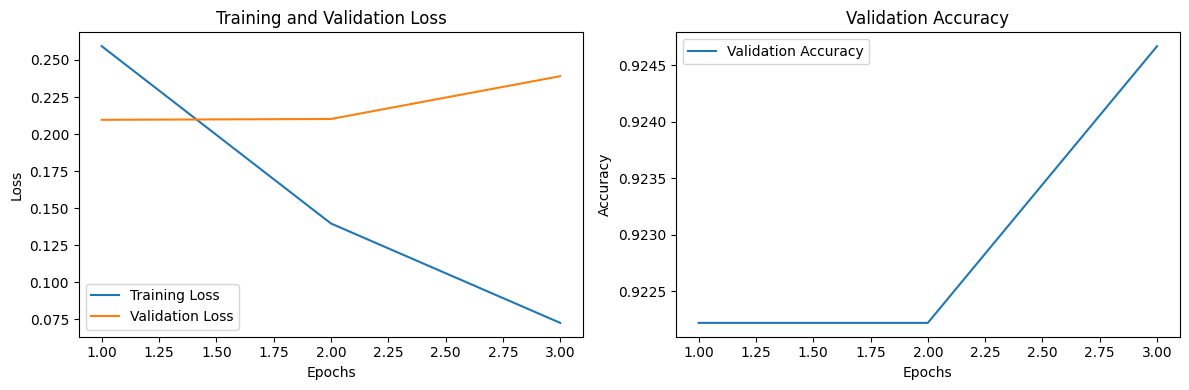

In [25]:
# plotting accuracy and loss curve
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history)

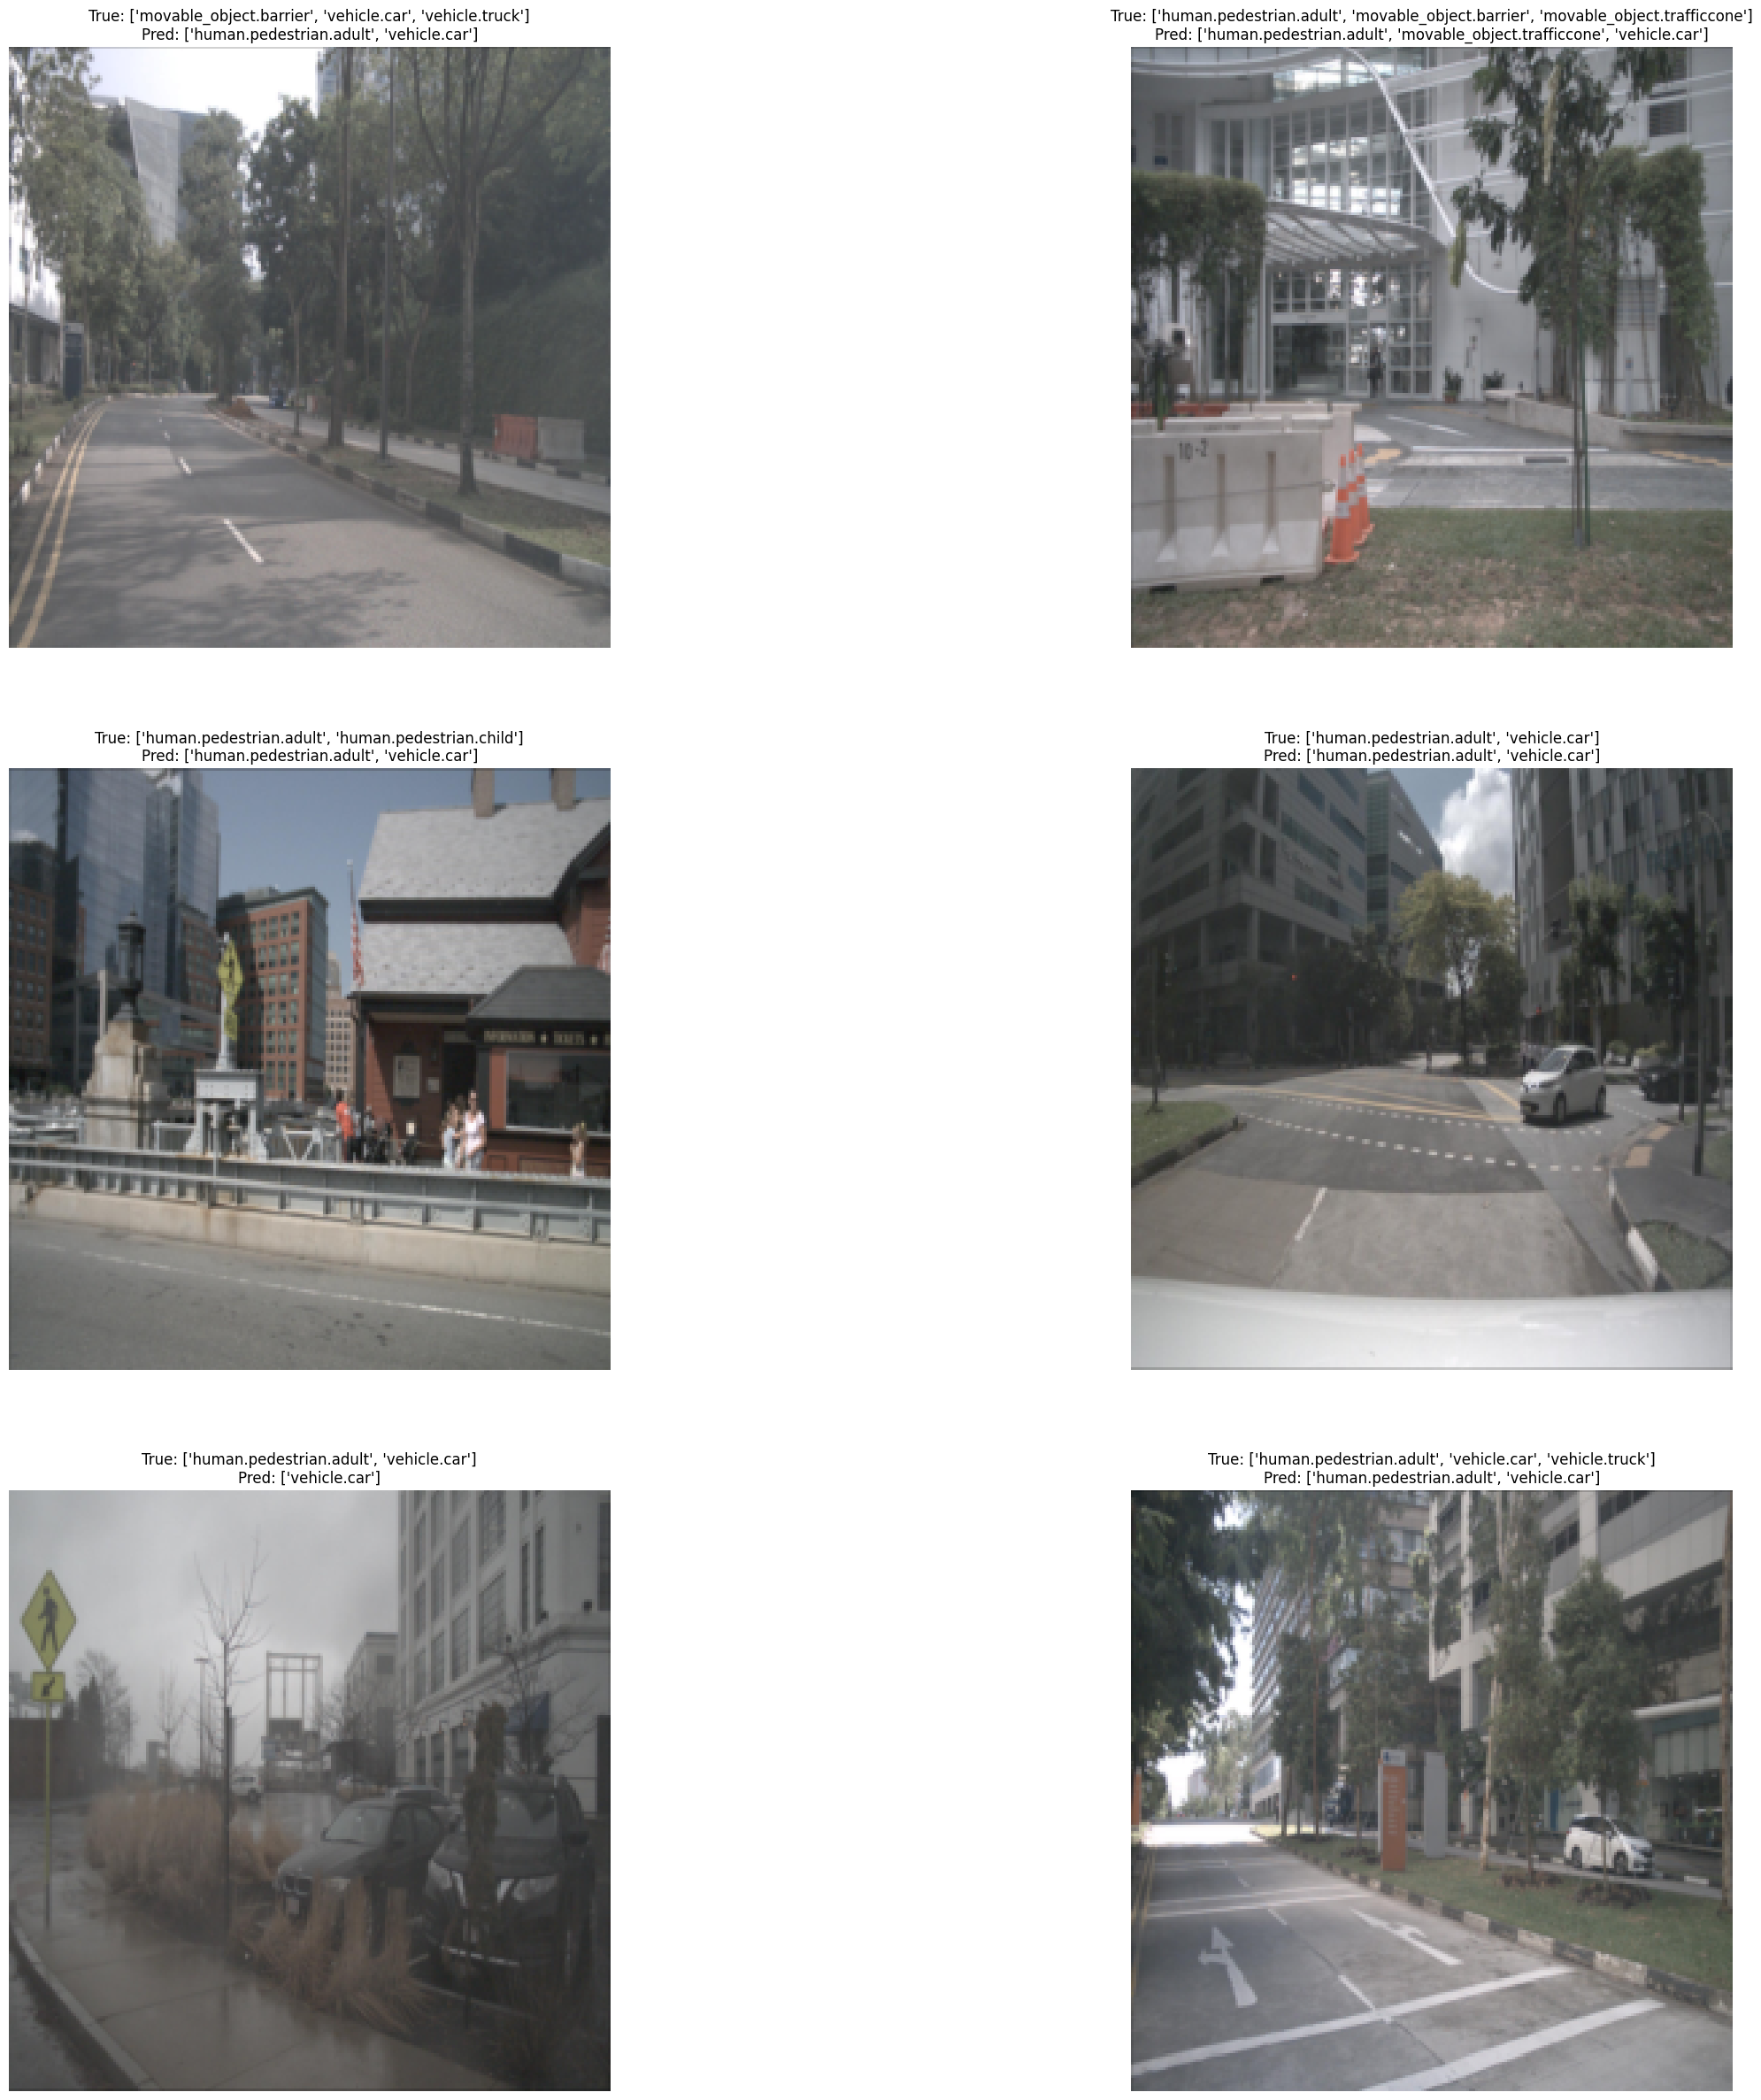

In [26]:
# plotting sample predicted outputs vs true labels from validation set

import matplotlib.pyplot as plt
import numpy as np


def tensor_to_image(tensor):
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    tensor = tensor.to('cpu').detach().numpy().transpose((1, 2, 0))
    tensor = np.clip(tensor, 0, 1)
    return tensor

def show_images_with_predictions(dataloader, model, device, categories, num_images=6):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(30, 30))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                predicted_labels = (outputs[j] > 0.5).int()
                pred_labels_text = [categories[idx]["name"] for idx, label in enumerate(predicted_labels) if label == 1]
                true_labels_text = [categories[idx]["name"] for idx, label in enumerate(labels[j]) if label == 1]

                ax.set_title(f"True: {true_labels_text}\nPred: {pred_labels_text}")
                plt.imshow(tensor_to_image(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train()
                    return
        model.train()

show_images_with_predictions(val_loader, model_vgg16, device, categories)


In [27]:
label_weights = np.array([
    1.0,  # animal
    0.1,  # flat.driveable_surface
    1.0,  # human.pedestrian.adult
    1.0,  # human.pedestrian.child
    1.0,  # human.pedestrian.construction_worker
    1.0,  # human.pedestrian.personal_mobility
    1.0,  # human.pedestrian.police_officer
    1.0,  # human.pedestrian.stroller
    1.0,  # human.pedestrian.wheelchair
    0.2,  # movable_object.barrier
    0.2,  # movable_object.debris
    0.3,  # movable_object.pushable_pullable
    0.2,  # movable_object.trafficcone
    0.1,  # static_object.bicycle_rack
    0.5,  # vehicle.bicycle
    0.4,  # vehicle.bus.bendy
    0.4,  # vehicle.bus.rigid
    0.4,  # vehicle.car
    0.4,  # vehicle.construction
    0.4,  # vehicle.ego
    0.6,  # vehicle.emergency.ambulance
    0.6,  # vehicle.emergency.police
    0.5,  # vehicle.motorcycle
    0.4,  # vehicle.trailer
    0.4   # vehicle.truck
])


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch

model_vgg16.eval()

all_preds = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_vgg16(inputs)
        predicted = (outputs > 0.5).float()

        all_preds.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_true_labels = np.array(all_true_labels)

sample_weights = np.dot(all_true_labels, label_weights)

precision = precision_score(all_true_labels, all_preds, average='samples', sample_weight=sample_weights)
recall = recall_score(all_true_labels, all_preds, average='samples', sample_weight=sample_weights)
f1 = f1_score(all_true_labels, all_preds, average='samples', sample_weight=sample_weights)

# If we dont want to weight
# precision = precision_score(all_true_labels, all_preds, average='micro')
# recall = recall_score(all_true_labels, all_preds, average='micro')
# f1 = f1_score(all_true_labels, all_preds, average='micro')

# print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.7225336322869952
Recall: 0.4315146985550572
F1 Score: 0.508172856042811


c:\Users\hrida\miniforge3\envs\new_environment\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hrida\miniforge3\envs\new_environment\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hrida\miniforge3\envs\new_environment\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
